In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import queue
import threading
import random

In [2]:
# create artificial clusters

def generate_clusters(n_clusters=3, d=2, n=100):
    centers = np.random.rand(n_clusters,d)*15
    cluster_std = np.random.normal(1, 0.2, n_clusters)
    X, y = make_blobs(n_samples=n, cluster_std=cluster_std, centers=centers, n_features=d, random_state=1)
    
    print("2d plot")
    for cluster in range(n_clusters):
        plt.scatter(X[y == cluster, 0], X[y == cluster, 1], s=10, label=f"Cluster{cluster}")  
    return centers, cluster_std, X, y

2d plot


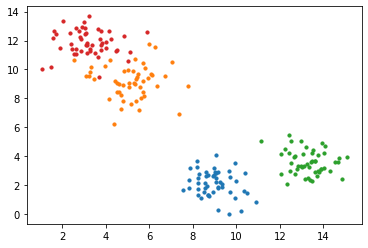

In [3]:
centers, cluster_std, X, y = generate_clusters(4,2,200)

In [4]:
# assign cluster to datapoint
def A(x, centers):
    distances = np.linalg.norm(centers - x, 2, 1)
    return int(np.argmin(distances))

In [5]:
def update_center(x, center, count, add=True):
    if add:
        center = (center*count+x)/(count+1)
        return center, count+1
    else:
        if (count - 1) > 0:
            center = (center*count-x)/(count-1)
        return center, max(0,count -1)

In [6]:
# update centers
def B(cluster_count, x, centers, id_cluster, previous_assignment, i):
    if id_cluster != previous_assignment[i]:
        # if not first assignment, then update center of previous cluster by removing x
        if previous_assignment[i] != -1:
            centers[previous_assignment[i]], cluster_count[previous_assignment[i]] = update_center(x,centers[previous_assignment[i]],cluster_count[previous_assignment[i]],add=False)
            cluster_count[previous_assignment[i]] -= 1
        # update center of new cluster assigned to
        centers[id_cluster], cluster_count[id_cluster] = update_center(x,centers[id_cluster],cluster_count[id_cluster],add=True)
        previous_assignment[i] = id_cluster
    return cluster_count, centers, previous_assignment

In [7]:
def k_means(X, n_clusters, n_iterations, d):
    centers = np.random.rand(n_clusters,d)*15
    cluster_count = np.zeros(n_clusters)
    previous_assignment = np.ones(n).astype(int)*(-1)
    for j in range(n_iterations):
        for i, x in enumerate(X):
            id_cluster = A(x,centers)
            cluster_count, centers, previous_assignment = B(cluster_count, x, centers, id_cluster, previous_assignment, i)
    return cluster_count, centers, previous_assignment 

# Parallel execution using queues

In [8]:
def k_means_optimized(X, n_clusters, n_iterations, d):
    n = len(X)
    centers = np.random.rand(n_clusters,d)*15
    cluster_count = np.zeros(n_clusters)
    previous_assignment = np.ones(n).astype(int)*(-1)
    queue_A = queue.Queue()
    [queue_A.put((i,x)) for i, x in enumerate(X)];
    queue_B = queue.Queue()
    
    def B_consumer():
        for j in range(n*n_iterations):
            i, x, id_cluster = queue_B.get()
            if id_cluster != previous_assignment[i]:
                # if not first assignment, then update center of previous cluster by removing x
                if previous_assignment[i] != -1:
                    centers[previous_assignment[i]], cluster_count[previous_assignment[i]] = update_center(x,centers[previous_assignment[i]],cluster_count[previous_assignment[i]],add=False)
                    cluster_count[previous_assignment[i]] -= 1
                # update center of new cluster assigned to
                centers[id_cluster], cluster_count[id_cluster] = update_center(x,centers[id_cluster],cluster_count[id_cluster],add=True)
                previous_assignment[i] = id_cluster
            queue_A.put((i, x))

    
    def A_producer():
        for j in range(n*n_iterations):
            # .get() is a blocking operation
            i, x = queue_A.get()
            id_cluster = A(x, centers)
            queue_B.put((i,x,id_cluster))
        
                
   
    
    
    # create a producer thread
    producer_thread = threading.Thread(target=A_producer, args=())
    # start the producer threa
    producer_thread.start()
    
    # create a consumer thread
    consumer_thread = threading.Thread(target=B_consumer, args=())
    # start the consumer thread
    consumer_thread.start()
    
    # wait for all threads to finish
    producer_thread.join()
    consumer_thread.join()
    
    return cluster_count, centers, previous_assignment 
    

# Speculation on centers

# Simulation

In [9]:
n_clusters = len(centers)
d = 2
true_centers = centers
n = len(X)
n_iterations = 100000

In [10]:
%%time

cluster_count, result, previous_assignment  = k_means(X, n_clusters, n_iterations, d)

Wall time: 4min 4s


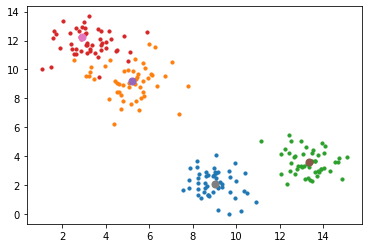

In [11]:
for cluster in range(n_clusters):
        plt.scatter(X[y == cluster, 0], X[y == cluster, 1], s=10, label=f"Cluster{cluster}")  
for center in result:
    plt.scatter(center[0], center[1], s=50)

# Simulation Optimized

In [12]:
%%time
cluster_count, centers, previous_assignment = k_means_optimized(X, n_clusters, n_iterations, d)

Wall time: 11min 50s


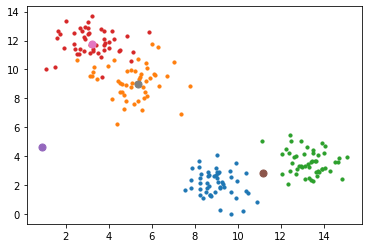

In [13]:
for cluster in range(n_clusters):
        plt.scatter(X[y == cluster, 0], X[y == cluster, 1], s=10, label=f"Cluster{cluster}")  
for center in centers:
    plt.scatter(center[0], center[1], s=50)

# Measurements

In [72]:
n = len(X)
n_clusters = 4
d = 2
n_iterations = 10
centers = np.random.rand(n_clusters,d)*15
cluster_count = np.zeros(n_clusters)
previous_assignment = np.ones(n).astype(int)*(-1)
queue_A = queue.Queue()
[queue_A.put((i,x)) for i, x in enumerate(X)];
queue_B = queue.Queue()
[queue_B.put((i,x, random.randint(0,n_clusters-1))) for i, x in enumerate(X)];

def B_consumer():
    while not queue_B.empty():
        i, x, id_cluster = queue_B.get()
        if id_cluster != previous_assignment[i]:
            # if not first assignment, then update center of previous cluster by removing x
            if previous_assignment[i] != -1:
                centers[previous_assignment[i]], cluster_count[previous_assignment[i]] = update_center(x,centers[previous_assignment[i]],cluster_count[previous_assignment[i]],add=False)
                cluster_count[previous_assignment[i]] -= 1
            # update center of new cluster assigned to
            centers[id_cluster], cluster_count[id_cluster] = update_center(x,centers[id_cluster],cluster_count[id_cluster],add=True)
            previous_assignment[i] = id_cluster
        


def A_producer():
    while not queue_A.empty():
        # .get() is a blocking operation
        i, x = queue_A.get()
        id_cluster = A(x, centers)

In [73]:
%%time
B_consumer()

Wall time: 51 ms


C:\Users\stefa\AppData\Local\Temp/ipykernel_7680/1850516115.py:3: RuntimeWarning: divide by zero encountered in true_divide
  center = (center*count+x)/(count+1)
C:\Users\stefa\AppData\Local\Temp/ipykernel_7680/1850516115.py:3: RuntimeWarning: invalid value encountered in multiply
  center = (center*count+x)/(count+1)


In [74]:
%%time
A_producer()

Wall time: 65 ms
